In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
import ktrain
from ktrain import text

In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import Markdown
from IPython.display import display

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv("./data/TrainVal.csv")
data.sample(10)

,tweet,label,tweet_cleaned,tweet_len
7468,Kalonji seeds (Nigella Seeds) contain hydroxyc...,fake,kalonji seed nigella seed contain hydroxychlor...,11
4437,@morris1_k @JMC_Starbug @andrewlawrence @Marti...,fake,eileen hot spot covid 19 also commonli 5g area,53
3982,Says the NIH ???15 years ago published a study...,fake,say nih 15 year ago publish studi chloroquin e...,16
835,5 death row inmates have died of #COVID19. htt...,real,5 death row inmat die covid 19,9
8545,Right now our model shows that: 📉4 states have...,real,right model show 📉 4 state reduc risk re-open ...,36
6648,Wearing a cloth face covering CORRECTLY can he...,real,wear cloth face cover correctli help prevent s...,44
512,Chinese scientists says COVID-19/coronavirus c...,fake,chines scientist say covid 19 coronaviru could...,23
144,India spraying pesticides at night to prevent ...,fake,india spray pesticid night prevent covid 19,8
3547,#COVID19 testing is free of cost in @ICMRDELHI...,real,covid 19 test free cost approv govt lab pvt la...,42
369,Some of the worst viral disease outbreaks in r...,fake,worst viral diseas outbreak recent year – sar ...,39


In [5]:
data.tweet.str.split().apply(len).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    8560.00000
mean       26.94778
std        22.45087
min         3.00000
25%        15.00000
50%        25.00000
75%        37.00000
90%        44.00000
95%        47.00000
max      1456.00000
Name: tweet, dtype: float64

In [6]:
data.label.value_counts()

real    4480
fake    4080
Name: label, dtype: int64

In [7]:
trn, val, preproc = text.texts_from_df(
    data,
    text_column = "tweet",
    label_columns="label",
    maxlen=50,
    ngram_range=1,
    random_state=41,
    preprocess_mode="standard"
)

['fake', 'real']
      fake  real
5065   1.0   0.0
4761   0.0   1.0
2623   1.0   0.0
7367   1.0   0.0
3498   1.0   0.0
['fake', 'real']
      fake  real
1214   1.0   0.0
6002   1.0   0.0
3262   1.0   0.0
5198   0.0   1.0
2164   0.0   1.0
language: en
Word Counts: 22133
Nrows: 7704
7704 train sequences
train sequence lengths:
	mean : 30
	95percentile : 51
	99percentile : 58
x_train shape: (7704,50)
y_train shape: (7704, 2)
Is Multi-Label? False
856 test sequences
test sequence lengths:
	mean : 28
	95percentile : 49
	99percentile : 56
x_test shape: (856,50)
y_test shape: (856, 2)


In [9]:
model = text.text_classifier('fasttext', trn , preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 50
done.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            1280000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 64)           0         
 ropout1D)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [11]:
learner = ktrain.get_learner(model, 
                             train_data=trn, 
                             val_data=val, 
                             batch_size=64)

In [12]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
121/121 [==============================] - 2s 9ms/step - loss: 1.0151 - accuracy: 0.4940
Epoch 2/1024
121/121 [==============================] - 1s 10ms/step - loss: 1.0154 - accuracy: 0.4861
Epoch 3/1024
121/121 [==============================] - 1s 9ms/step - loss: 1.0086 - accuracy: 0.4844
Epoch 4/1024
121/121 [==============================] - 1s 9ms/step - loss: 1.0086 - accuracy: 0.4883
Epoch 5/1024
121/121 [==============================] - 1s 9ms/step - loss: 0.9856 - accuracy: 0.4925
Epoch 6/1024
121/121 [==============================] - 1s 9ms/step - loss: 0.9132 - accuracy: 0.5232
Epoch 7/1024
121/121 [==============================] - 1s 9ms/step - loss: 0.7681 - accuracy: 0.5911
Epoch 8/1024
121/121 [==============================] - 1s 9ms/step - loss: 0.5439 - accuracy: 0.7313
Epoch 9/1024
121/121 [==============================] - 1s 9ms/step - loss: 0.3220 - accuracy: 0.860

Three possible suggestions for LR from plot:
	Longest valley (red): 5.10E-04
	Min numerical gradient (purple): 3.33E-04
	Min loss divided by 10 (omitted from plot): 2.07E-03


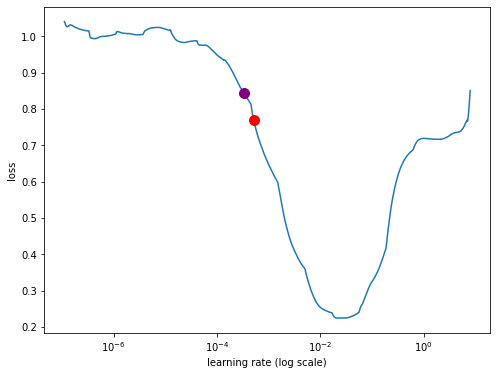

In [13]:
learner.lr_plot(suggest=True)

In [14]:
import gc
gc.collect()

6328

In [15]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.fit_onecycle(5.10E-04, 10)



begin training using onecycle policy with max lr of 0.00051...
Epoch 1/10
121/121 [==============================] - 2s 11ms/step - loss: 0.9617 - accuracy: 0.5065 - val_loss: 0.6877 - val_accuracy: 0.5199
Epoch 2/10
121/121 [==============================] - 1s 10ms/step - loss: 0.8008 - accuracy: 0.5658 - val_loss: 0.6668 - val_accuracy: 0.5315
Epoch 3/10
121/121 [==============================] - 1s 10ms/step - loss: 0.6439 - accuracy: 0.6676 - val_loss: 0.5917 - val_accuracy: 0.7944
Epoch 4/10
121/121 [==============================] - 1s 10ms/step - loss: 0.5094 - accuracy: 0.7600 - val_loss: 0.4221 - val_accuracy: 0.9124
Epoch 5/10
121/121 [==============================] - 1s 10ms/step - loss: 0.3905 - accuracy: 0.8231 - val_loss: 0.2669 - val_accuracy: 0.9252
Epoch 6/10
121/121 [==============================] - 1s 10ms/step - loss: 0.3019 - accuracy: 0.8679 - val_loss: 0.1960 - val_accuracy: 0.9287
Epoch 7/10
121/121 [==============================] - 1s 10ms/step - loss: 0.

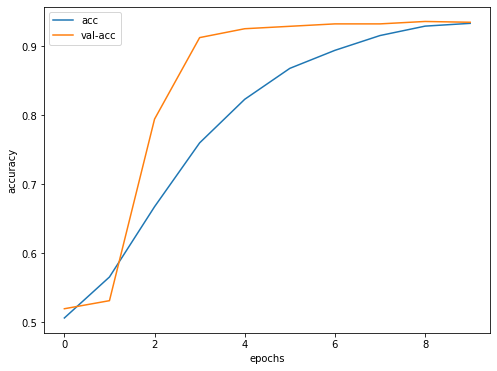

In [16]:
plt.plot(learner.history.history["accuracy"])
plt.plot(learner.history.history["val_accuracy"])
plt.legend(["acc", "val-acc"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

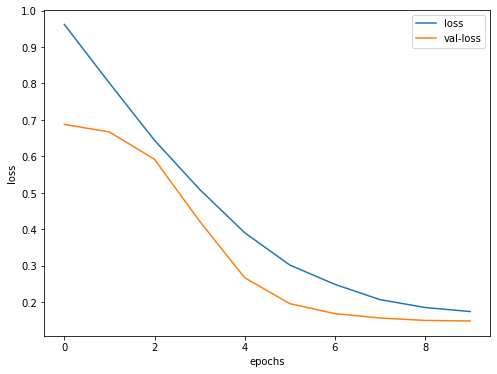

In [17]:
plt.plot(learner.history.history["loss"])
plt.plot(learner.history.history["val_loss"])
plt.legend(["loss", "val-loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [19]:
test_data = pd.read_csv("./data/TestLabel.csv", index_col=0)
test_data.sample(10)

,tweet,label
id,,
2008,@GregoryIngle @flvickster @vivek_mutalik Yeah ...,real
1220,#IndiaFightsCorona: Active cases only 22% of t...,real
1079,"Professor Clifford Stott says we should ""pay a...",real
104,Access the #COVID19 Management Assessment and ...,real
1334,China has successfully tested an anti-coronavi...,fake
87,One state situation worth highlighting is Mich...,real
530,Says Dr. Anthony Fauci ???stands to lose 100 m...,fake
50,Our daily update is published. States reported...,real
1172,A viral video post claiming that Myanmar peopl...,fake


In [20]:
probs = predictor.predict_proba(test_data["tweet"].values)
probs[:5]

array([[1.6317695e-03, 9.9836820e-01],
       [9.9889201e-01, 1.1080439e-03],
       [9.9959844e-01, 4.0161028e-04],
       [2.9385400e-03, 9.9706143e-01],
       [9.3980459e-03, 9.9060202e-01]], dtype=float32)

In [21]:
y = (test_data.label == "real")
y.head()

id
1     True
2    False
3    False
4     True
5     True
Name: label, dtype: bool

In [22]:
import metrics as mmetrics

In [23]:
y = y.values.reshape((-1, 1))

perfs = mmetrics.get_performance_metrics(y, probs[:, 1:], ["fasttext"])
perfs

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
fasttext,1043,957,63,77,0.935,0.523,0.931,0.938,0.943,0.926,0.985,0.937,0.5
